Check Python version

In [1]:
!python --version

Python 3.9.0


Import libraries

In [2]:
import json
import yaml
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### **Extract Data**

In [3]:
file_name = 'temp_anom_w_forcing.csv'

In [4]:
dataset = pd.read_csv(file_name)

In [5]:
dataset.shape

(163, 11)

In [6]:
dataset.columns

Index(['Year', 'WMGHG', 'Ozone', 'Solar', 'Land_Use', 'SnowAlb_BC', 'Orbital',
       'TropAerDir', 'TropAerInd', 'StratAer', 'Anomaly'],
      dtype='object')

In [7]:
dataset.head()

,Year,WMGHG,Ozone,Solar,Land_Use,SnowAlb_BC,Orbital,TropAerDir,TropAerInd,StratAer,Anomaly
0,1850,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.17
1,1851,0.005954,0.000745,0.001166,-0.000940,0.000649,0.000653,0.000649,-0.000005,0.029088,-0.09
2,1852,0.010502,0.000909,-0.010756,-0.002531,0.000649,0.000671,0.000649,-0.000005,0.056712,-0.11
3,1853,0.014587,0.001020,-0.027220,-0.004123,0.000649,0.000688,0.000649,-0.000005,0.077260,-0.12
4,1854,0.020521,0.001188,-0.045539,-0.005717,0.000649,0.000689,0.000649,-0.000005,0.085759,-0.12


In [8]:
dataset.tail()

,Year,WMGHG,Ozone,Solar,Land_Use,SnowAlb_BC,Orbital,TropAerDir,TropAerInd,StratAer,Anomaly
158,2008,3.36688,0.451834,-0.009377,-0.205278,0.053937,0.002234,-0.189395,-0.697385,0.059742,0.55
159,2009,3.40963,0.451834,-0.006203,-0.205278,0.053937,0.002241,-0.189395,-0.697385,0.040626,0.66
160,2010,3.45082,0.451834,0.020822,-0.205278,0.053937,0.002254,-0.189395,-0.697385,0.081508,0.73
161,2011,3.49278,0.451834,0.058369,-0.205278,0.053937,0.002261,-0.189395,-0.697385,0.088224,0.62
162,2012,3.53407,0.451834,0.095752,-0.205278,0.053937,0.002277,-0.189395,-0.697385,0.088224,0.66


Define the required time and target columns

In [9]:
time_col = dataset.columns[0]
target_col = dataset.columns[-1]
dataset[time_col] = dataset[time_col].astype(str)

Change target column to float

In [10]:
# dataset[target_col] = dataset[target_col].astype(float)

In [11]:
# dataset.head()

Split dataset into train and test sets

In [12]:
train_size = 0.8
train_points = int(train_size*len(dataset))
train_df = dataset.iloc[:train_points]
test_df = dataset.iloc[train_points:]

Plot graph

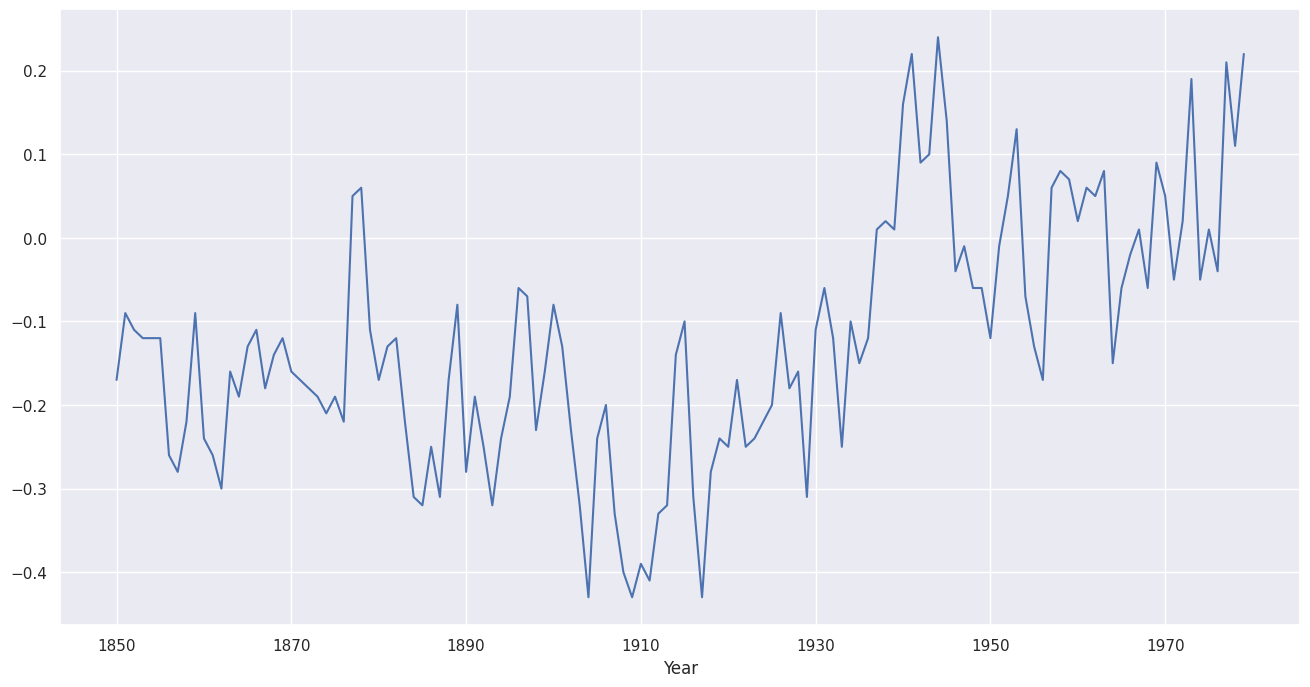

In [13]:
figsize = (16, 8)
train_df.set_index(time_col)[target_col].plot(figsize=figsize);

### **Train API**

Train data: convert df to list-of-list

In [14]:
train_data = []
for value in train_df.values:
    train_data.append(list(value))

In [15]:
train_data[:2]

[['1850', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.17],
 ['1851',
  0.00595381,
  0.0007451,
  0.00116604,
  -0.0009399,
  0.00064918,
  0.00065287,
  0.00064918,
  -4.97297e-06,
  0.0290878,
  -0.09]]

Custom Model Request (optional)

In [16]:
# Default model request
# model_request = {
#     'type': 'meta_wa',
#     'scorers': ['smape', 'mase'],
#     'params': {
#         'preprocessors': [
#             {'type': 'dartsimputer'},
#             {'type': 'minmaxscaler'},
#         ],
#         'base_models': [
#             # {'type': 'darts_naive'},
#             {'type': 'darts_seasonalnaive'},
#             # {'type': 'darts_autotheta'},
#             # {'type': 'darts_autoarima'},
#             # {'type': 'darts_autoets'},
#         ],
#     },
# }

# # Onboard NeuralProphet customized model request
# np_external_model_request = {
#     'params': {
#       'changepoints_range': 0.2,
#       'epochs': 2,
#       'growth': 'off'
#     },
#     'metrics': [],
#     'type': 'neuralprophet',
# }
# # np_external_model_request = None

user_value = 0.9
output_type = 'estimate'  # 'data', 'estimate'
mauq_external_params = {
    'problem_type': 'regression',
    'confidence_level': user_value,
    'output_type': output_type

}

deepsybil_external_model_request = {
    'type': 'meta_wa',  # 'meta_naive', 'meta_wa'
    'scorers': ['mase', 'smape'],
    'params': {
        'preprocessors': [
            # {'type': 'dartsimputer'},
            # {'type': 'simpleimputer', 'params': {'strategy': 'mean'}},
            {'type': 'minmaxscaler'},
        ],
        'base_models': [
            # {'type': 'darts_rnn',
            #  'params': {
            #      'model': 'LSTM',
            #      'hidden_dim': 10,
            #      'n_rnn_layers': 3
            # }},
            # {'type': 'darts_tcn',
            #  'params': {
            #      'output_chunk_length': 52,
            #      'input_chunk_length': 104,                 
            #      'n_epochs': 20,
            # }},
            # {'type': 'darts_rnn',
            #  'params': {
            #      'model': 'LSTM',
            #      'hidden_dim': 10,
            #      'n_rnn_layers': 3
            # }},
            {'type': 'darts_nlinear'},
            {'type': 'darts_dlinear'},
            # {'type': 'darts_blockrnn'},
            # {'type': 'darts_tsmixer',
            #  'params': {
            #      'output_chunk_length': 52,
            #      'input_chunk_length': 104,                 
            #      'n_epochs': 20,
            # }},
            #  {'type': 'darts_tide'}
        ],
    },
}


# # Customized model request
model_request = {
    'type': 'meta_wa',  # 'meta_naive', 'meta_wa'
    'scorers': ['mase', 'smape'],
    'params': {
        'preprocessors': [
            {'type': 'dartsimputer'},
            {'type': 'simpleimputer', 'params': {'strategy': 'mean'}},
            {'type': 'minmaxscaler'},
        ],
        'base_models': [
            # {'type': 'darts_naive'},
            # {'type': 'darts_seasonalnaive'},
            # {'type': 'darts_autotheta'},
            # {'type': 'stats_autotheta'},
            # {'type': 'darts_autoets'},
            # {'type': 'stats_autoets'},
            # {'type': 'darts_autoarima'},
            # {'type': 'stats_autoarima'},
            # {'type': 'darts_autoces'},
            # {'type': 'darts_kalman'},
            # {'type': 'darts_catboost'},            
            # # {'type': 'darts_tbats'},
            # # {'type': 'darts_linearregression'},
            # {'type': 'darts_lightgbm',
            #  'params': {
            #      'lags': 12,
            #      'output_chunk_length': 6,
            #      'verbose': -1
            # }}
            # {'type': 'neuralprophet',
            #  'external_params': np_external_model_request
            # }  # Onboard NeuralProphet external service
            {'type': 'deepsybil',
             'external_params': deepsybil_external_model_request
            }  # Onboard NeuralProphet external service
        ],
        
    },
    'mauq_params':mauq_external_params,
}

This is for JSON model_request

In [17]:
# file_path = 'model_request.json'
# # For writing the model request to a json file
# with open(file_path, 'r') as file:
#     model_request = json.load(file)

This is for YAML model_request

In [18]:
# file_path = 'model_request.yaml'
# # For reading the model request from a yaml file
# with open(file_path, 'r') as file:
#     model_request = yaml.safe_load(file)

Train API JSON Payload

In [19]:
api_json = {
    'data': train_data,
    'model': model_request  # (optional) can be commented out
}

Build URL

In [20]:
with open('url.yaml', 'r') as file:
    url_dict = yaml.safe_load(file)

In [21]:
# URL to our SYBIL AWS service
protocol = url_dict['protocol']
host = url_dict['host']
port = url_dict['port']
endpoint = 'train'

url = '%s://%s:%s/%s' % (protocol, host, str(port), endpoint)

In [22]:
# protocol, host, port

Call endpoint, receive response JSON, write to output file

In [23]:
%%time
response = requests.post(url, json=api_json)
print(response)
print()

<Response [200]>

CPU times: user 10.5 ms, sys: 2.52 ms, total: 13.1 ms
Wall time: 1min 33s


In [24]:
train_json_out = response.json()  # dict output
train_json_out

{'model': 'AgEBCDStAQAwrQEAMKIBABgAAAAoogEAbC8AAD+AAGVsaZOMb5Rsb4xtlARhaZRzcmGUKIwudG2UTZNhLhRscGwVb2kMdIyMeUMolHAxKE7/YgDgiQAYdYyTh1IYY2VlX5RzbnUKZChoaAECUpT/dOAAqh+UlB1jZWUSdGSMbZMTX3JfaUFrcG95aWFyuJSJBP9Lcwp0HSJLTZRO/0MBlOAAM+BwAB+UX4dplF9hlGQFlHNsbGF1U3Apc5SMYWFyc2V9EmxnlB+Mkx0iS0+UTv+JjIyMjGVjdF2FKCeHR/90tX3zx6fmox3cgZSUaIcJKKKmS2E0BIyUdq9vS3V6c2GUdZRohSjgeuDgCAARMZSUaB0iS5RoaGiUaFxohShq4Agi4GgAH3SMLnNmWW4BY4xLS2V7lHMMYyltbW0Gk1GUX7O4dWVlH2xzTZOMb2plV5OMYmxsbl+MQmJlZ3l0c11lZWENZZSMH3NhbZQAX5QAX5R5ZYxzb18Eam2MaWluAUFBd2xBYmNiH2FabGRibGJjWWxUYktqU2ViRkxiY0JjYmpaWmxqVFNBH0FBbFhRQWxqYlpiWWxZVmdDYmxqY1pnSWRaY2FhalpaH2dFYmRqZWJZRVpkY1ROWFpkYmxqWmRUTllLbGNka2JlH2hoQWFsbFQvL2lRUTVQdDFwOVF3NnlxTlczQWdYQTZyH2NtODdqRnFkTXVrSzJjSm96emNwZS9oRkJScE9rUXM0H3A3eDUwbE5oMWNTL01mZllSYWIxNmx2bkRvYzlicDR2H0lIQjFRYVZ3TldhK0JUZzUrS0ZqTEVsNG5Za1owckx3H0hCRk91RTJIMEltSkpaTmhqMUM3RUZxc0lLU1dxRmt5HzdJeWxyQ0NXYTJQV25DTjZ6RUk0eFlGV2ptT0lmbTVmH1QvNUpibUttZWx2ZitoNWZoUmE4LzBQbzBzMzd1Umt1H1FaSUU5ajNHRDNhVmZEL1J6a

In [25]:
estimate=train_json_out['estimate']

### **Forecast API**

Forecast Dates: predict the next 32 years of temperature anomaly data (1980-2012)

In [26]:
test_data = []
for value in test_df.drop(columns=target_col).values:
    test_data.append(list(value))

In [27]:
test_data[:2]

[['1980',
  2.09837,
  0.362496,
  0.132923,
  -0.197799,
  0.0534377,
  0.00195668,
  -0.116014,
  -0.557516,
  -0.0294989],
 ['1981',
  2.15487,
  0.37198,
  0.13994,
  -0.198391,
  0.0534899,
  0.00196222,
  -0.12073,
  -0.572096,
  -0.0378411]]

Model from Train API

In [28]:
model = train_json_out['model']

Forecast API JSON Payload

In [29]:
api_json = {
    'model': model,
    'data': test_data,
    'estimate':estimate
}

Build URL (same as train except for the endpoint)

In [30]:
endpoint = 'forecast'

url = '%s://%s:%s/%s' % (protocol, host, str(port), endpoint)

Call endpoint, receive response JSON, write to output file

In [31]:
%%time
response = requests.post(url, json=api_json)
print(response)
print()

<Response [200]>

CPU times: user 7.25 ms, sys: 1.41 ms, total: 8.67 ms
Wall time: 566 ms


In [32]:
forecast_json_out = response.json()  # dict output
forecast_json_out

{'data': [['1980',
   0.18639025126582548,
   -0.03832735953193081,
   0.41110786206358174],
  ['1981', 0.17864286153825776, -0.04607474925949853, 0.403360472336014],
  ['1982', 0.18462292994470958, -0.04009468085304671, 0.40934054074246584],
  ['1983', 0.1909391483654463, -0.03377846243231, 0.41565675916320255],
  ['1984', 0.18969246368007026, -0.035025147117686034, 0.4144100744778265],
  ['1985', 0.18564215067539064, -0.03907546012236565, 0.4103597614731469],
  ['1986', 0.18236213602469314, -0.042355474773063145, 0.4070797468224494],
  ['1987', 0.1831773404501011, -0.0415402703476552, 0.40789495124785735],
  ['1988', 0.18542528270320974, -0.03929232809454655, 0.410142893500966],
  ['1989', 0.1864227493645591, -0.038294861433197186, 0.41114036016231537],
  ['1990', 0.1858670607901008, -0.0388505500076555, 0.41058467158785705],
  ['1991', 0.18418633591541417, -0.04053127488234212, 0.40890394671317043],
  ['1992', 0.18088845459967456, -0.043829156198081726, 0.4056060653974308],
  ['1993

Combine forecast dates and output

In [33]:
forecast_df = pd.DataFrame(
    data=forecast_json_out['data'],
    columns=[time_col, target_col,"lower_interval","upper_interval"],
)

In [34]:
forecast_df.shape

(33, 4)

In [35]:
forecast_df.columns

Index(['Year', 'Anomaly', 'lower_interval', 'upper_interval'], dtype='object')

In [36]:
forecast_df.head()

,Year,Anomaly,lower_interval,upper_interval
0,1980,0.186390,-0.038327,0.411108
1,1981,0.178643,-0.046075,0.403360
2,1982,0.184623,-0.040095,0.409341
3,1983,0.190939,-0.033778,0.415657
4,1984,0.189692,-0.035025,0.414410


In [37]:
forecast_df.tail()

,Year,Anomaly,lower_interval,upper_interval
28,2008,0.182299,-0.042418,0.407017
29,2009,0.183438,-0.041279,0.408156
30,2010,0.182650,-0.042068,0.407367
31,2011,0.181745,-0.042973,0.406462
32,2012,0.181183,-0.043535,0.405901


Plot train and forecast side-by-side

/tmp/ipykernel_27658/2998340865.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['color'] = 'b'


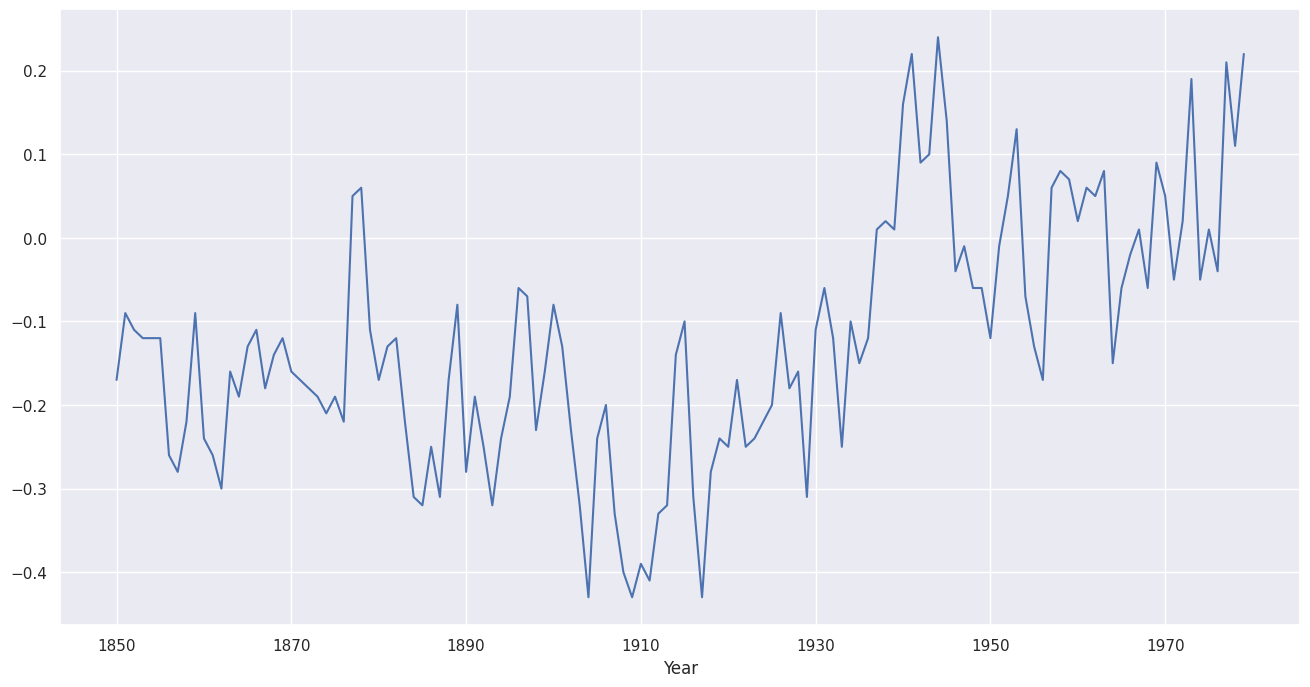

In [38]:
train_df['color'] = 'b'
train_df.set_index(time_col)[target_col].plot(figsize=figsize, color=train_df['color']);

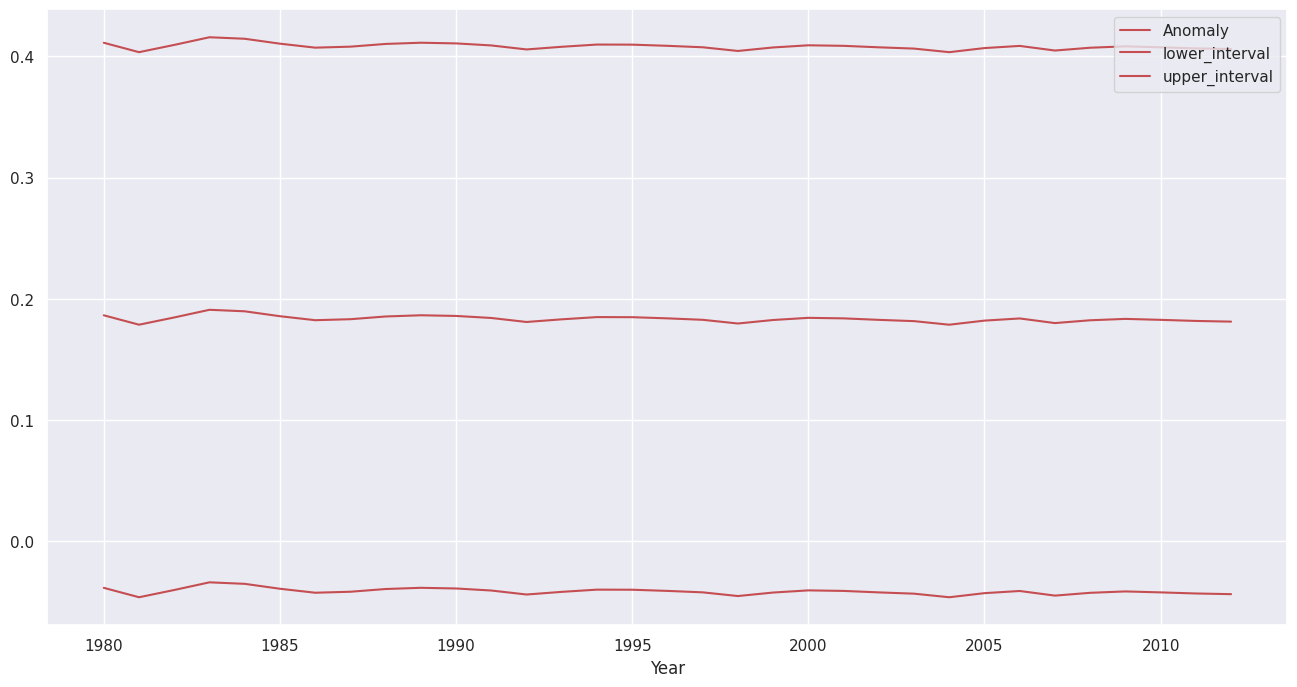

In [39]:
forecast_df['color'] = 'r'
forecast_df.set_index(time_col).plot(figsize=figsize, color=forecast_df['color']);

Combine train and forecast sets

In [40]:
df = pd.concat([train_df, forecast_df]).reset_index(drop=True)

In [41]:
df.shape

(163, 14)

In [42]:
df.head()

,Year,WMGHG,Ozone,Solar,Land_Use,SnowAlb_BC,Orbital,TropAerDir,TropAerInd,StratAer,Anomaly,color,lower_interval,upper_interval
0,1850,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.17,b,NaN,NaN
1,1851,0.005954,0.000745,0.001166,-0.000940,0.000649,0.000653,0.000649,-0.000005,0.029088,-0.09,b,NaN,NaN
2,1852,0.010502,0.000909,-0.010756,-0.002531,0.000649,0.000671,0.000649,-0.000005,0.056712,-0.11,b,NaN,NaN
3,1853,0.014587,0.001020,-0.027220,-0.004123,0.000649,0.000688,0.000649,-0.000005,0.077260,-0.12,b,NaN,NaN
4,1854,0.020521,0.001188,-0.045539,-0.005717,0.000649,0.000689,0.000649,-0.000005,0.085759,-0.12,b,NaN,NaN


In [43]:
df.tail()

,Year,WMGHG,Ozone,Solar,Land_Use,SnowAlb_BC,Orbital,TropAerDir,TropAerInd,StratAer,Anomaly,color,lower_interval,upper_interval
158,2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.182299,r,-0.042418,0.407017
159,2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.183438,r,-0.041279,0.408156
160,2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.182650,r,-0.042068,0.407367
161,2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.181745,r,-0.042973,0.406462
162,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.181183,r,-0.043535,0.405901


In [44]:
df['Anomaly']

0     -0.170000
1     -0.090000
2     -0.110000
3     -0.120000
4     -0.120000
         ...   
158    0.182299
159    0.183438
160    0.182650
161    0.181745
162    0.181183
Name: Anomaly, Length: 163, dtype: float64

In [45]:
dataset

,Year,WMGHG,Ozone,Solar,Land_Use,SnowAlb_BC,Orbital,TropAerDir,TropAerInd,StratAer,Anomaly
0,1850,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.17
1,1851,0.005954,0.000745,0.001166,-0.000940,0.000649,0.000653,0.000649,-0.000005,0.029088,-0.09
2,1852,0.010502,0.000909,-0.010756,-0.002531,0.000649,0.000671,0.000649,-0.000005,0.056712,-0.11
3,1853,0.014587,0.001020,-0.027220,-0.004123,0.000649,0.000688,0.000649,-0.000005,0.077260,-0.12
4,1854,0.020521,0.001188,-0.045539,-0.005717,0.000649,0.000689,0.000649,-0.000005,0.085759,-0.12
...,...,...,...,...,...,...,...,...,...,...,...
158,2008,3.366880,0.451834,-0.009377,-0.205278,0.053937,0.002234,-0.189395,-0.697385,0.059742,0.55
159,2009,3.409630,0.451834,-0.006203,-0.205278,0.053937,0.002241,-0.189395,-0.697385,0.040626,0.66
160,2010,3.450820,0.451834,0.020822,-0.205278,0.053937,0.002254,-0.189395,-0.697385,0.081508,0.73
161,2011,3.492780,0.451834,0.058369,-0.205278,0.053937,0.002261,-0.189395,-0.697385,0.088224,0.62


Plot combined train and forecast sets with the vertical black line as the cut-off

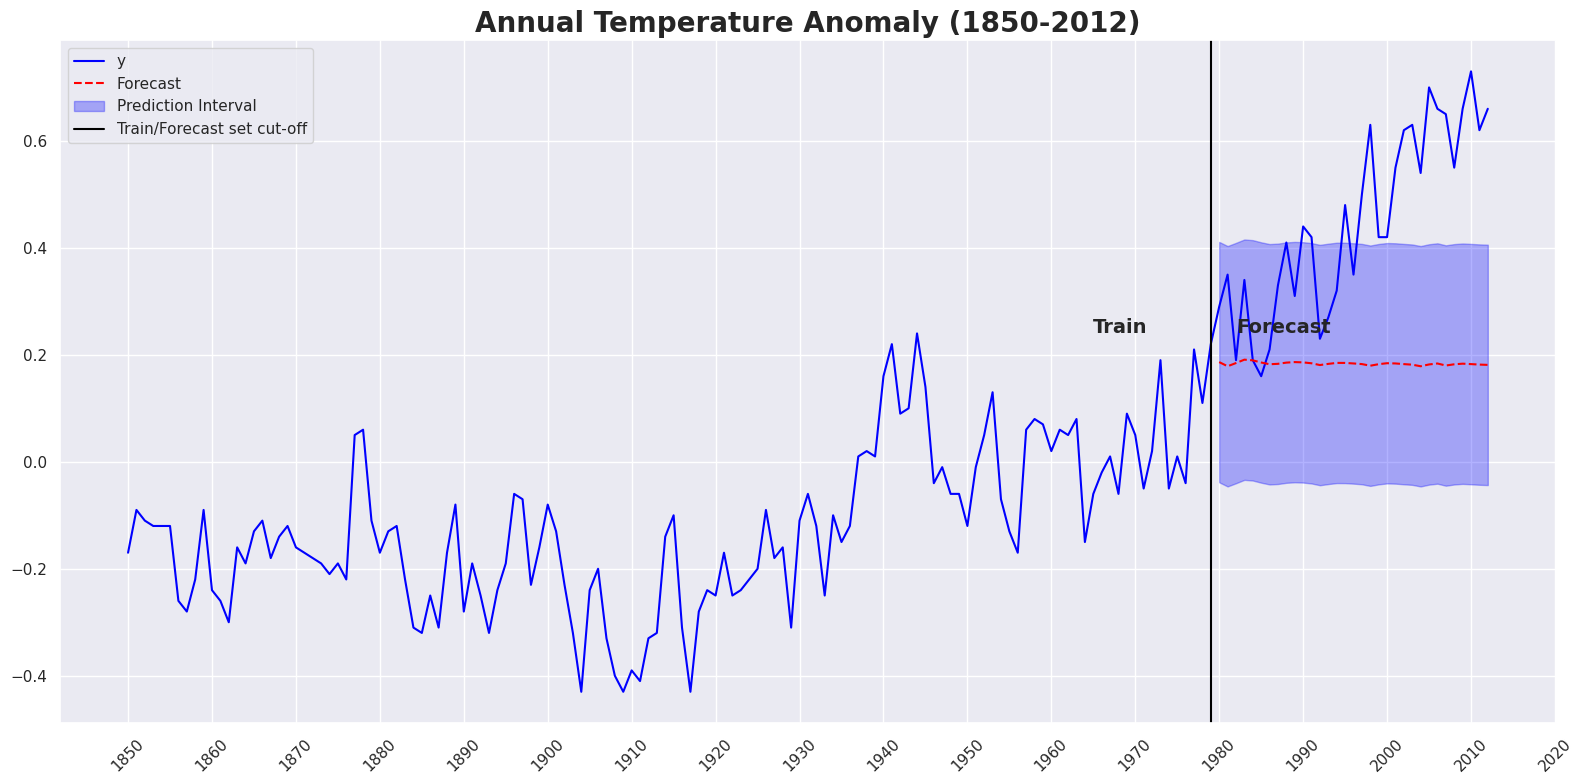

In [46]:
import matplotlib.dates as mdates

# Ensure time_col is datetime
df[time_col] = pd.to_datetime(df[time_col])
forecast_df[time_col] = pd.to_datetime(forecast_df[time_col])

plt.figure(figsize=figsize)
dataset['Year'] = pd.to_datetime(dataset['Year'], format='%Y')

plt.plot(dataset[time_col], dataset[target_col], color='blue', label='y')

plt.plot(forecast_df[time_col], forecast_df[target_col], color='red', linestyle='dashed', label='Forecast')

plt.fill_between(forecast_df[time_col], forecast_df['lower_interval'], forecast_df['upper_interval'], 
                 color='blue', alpha=0.3, label='Prediction Interval')

plt.axvline(x=df[time_col].iloc[len(train_df)-1], color='black', label='Train/Forecast set cut-off')

plt.text(df[time_col].iloc[len(train_df)-15], df[target_col].max(), 'Train', fontweight='bold', fontsize=14)
plt.text(df[time_col].iloc[len(train_df)+2], df[target_col].max(), 'Forecast', fontweight='bold', fontsize=14)

# Format x-axis to show years clearly
plt.gca().xaxis.set_major_locator(mdates.YearLocator(10))  # every 10 years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

plt.title('Annual Temperature Anomaly (1850-2012)', fontweight='bold', fontsize=20)
plt.legend()
plt.tight_layout()
plt.show()


